In [11]:
from math import pi
import matplotlib.pyplot as plt
# from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import AdamOptimizer
import datetime
now=datetime.datetime.now

In [12]:
num_qubits=2
dev=qml.device('default.qubit', wires=num_qubits)

# define my own embedding layer
# def myembedding(x,wires):
#     # qml.RY(np.arcsin(x), wires=wires[0])
#     # qml.RY(2*pi*x, wires=wires[1])

def myembedding(x,wires):
    qml.RY(x, wires=wires[1])

def Ham():
    obs=[]
    for j in range(num_qubits):
        obs.append(qml.PauliX(j))
        for k in range(j):
            obs.append(qml.PauliZ(j)@qml.PauliZ(k))
    coeffs=np.random.uniform(-1,1,len(obs))*10
    qml.Hamiltonian(coeffs, obs)

# define ansastz layer
def layer(theta):
    
    # Apply Hamiltonian matrix
    Ham()
    
    # Apply H gate
    qml.Hadamard(0)
    
    # rotations on qubits
    qml.RY(theta[0],wires=0)
    qml.RY(theta[1],wires=1)
    
    # CNOT
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev)
def quantum_net(theta,x):
    
    # encode data
    myembedding(x,wires=range(num_qubits))
    
    # parameterized circuit layers
    for v in theta: # (for lool along with the first dimension)
        # Ham()
        layer(v)
    
    qml.Hadamard(0)
    
    return qml.expval(qml.PauliZ(0))

In [13]:

# print(theta.shape)
# # print(theta)
# print(qml.draw(quantum_net)(theta,0))



# add the classical layer
def classical_quantum_net(theta,w,x):
    r=quantum_net(theta,x)
    return w[0]+w[1]*r+w[2]*r**2
    # return w[0]+w[1]*r



In [14]:
import numpy as np
from scipy.optimize import minimize


def f(theta,w, t):
    r=quantum_net(theta,t)
    return w[0]+w[1]*r+w[2]*r**2


# Differential equation parameters
ws = 376.9911
# Boundary condition 
coefii = 10

# del_0 = 0  #del
# omega_0 = 0     #w
# del_0_v = -1/coefii
# omega_0_v = 383.9911/coefii
del_0_v = 0.052017650370403824
omega_0_v = 37.52520789865456

K1 = 5/coefii
K2 = 10/coefii
K3 = 1.7/coefii
ws = ws/coefii
def DE(f,f_prime,f_double_prime,t):
    delta = f
    delta_prime = f_prime
    omega = delta_prime+ws
    omega_prime = f_double_prime
    return (delta_prime+ws-omega)+omega_prime-K1+K2*np.sin(coefii*delta)+K3*(-ws+omega)*coefii
    

n_grid = 20
range_min = 2.5
range_max = 3
t_data = np.linspace(range_min, range_max, n_grid)
dt = t_data[1]-t_data[0]
# print(dt)
print(t_data)
# del_target_values = [-0.1, -0.08568864375010266, -0.07135199292327042, -0.05703216366155178, -0.04277533332758968, -0.028630566403092566, -0.014648393492369936, -0.0008786099410683636, 0.012629993562057113, 0.025830965225360485, 0.03868190003112095, 0.05114514907683676, 0.06318818053413534, 0.07478349631699908, 0.08590929364185632, 0.09655108128205876, 0.10669910851327256, 0.11634802541217151, 0.12549688285643618, 0.13414913252475494, 0.1423124546002818, 0.14999727816970396, 0.1572170147933966, 0.16398646160587024, 0.17032150117763253, 0.17623910151518826, 0.18175731606103976, 0.18689528211221512, 0.19167252338163385, 0.1961073022258, 0.2002172705183872, 0.2040196495808423, 0.20753123018238517, 0.21076837254000894, 0.21374700631847987, 0.2164826306303374, 0.21899031403589397, 0.22128469454323552, 0.2233792634241711, 0.22528520015009165, 0.22701309424038968, 0.22857304585789437, 0.22997466468065175, 0.2312270699019247, 0.23233889023019288, 0.23331826388915283, 0.23417283861771784, 0.2349097716700181, 0.2355355471757422, 0.23605508170803655]
# omega_target_values = [38.39911, 38.40131255162024, 38.401559501400065, 38.399627615014815, 38.39535272010845, 38.38863569037213, 38.37944575798523, 38.36781828175373, 38.35385457506316, 38.33771250498817, 38.31960064799821, 38.29975795463622, 38.27844654658136, 38.25594953663366, 38.232548774138536, 38.20852344187769, 38.184133101993716, 38.15961422638989, 38.135180196730154, 38.11102130443908, 38.0873045267779, 38.0641648590319, 38.04170495996719, 38.020008128295665, 37.999139183467754, 37.979144465672405, 37.96005183583712, 37.94187079269068, 37.92460193204962, 37.90823330461032, 37.892744190413474, 37.87811073974539, 37.864305973137945, 37.851299781368624, 37.83905892546051, 37.82754703668229, 37.816724616548235, 37.80654903681822, 37.7969789305147, 37.78797953688034, 37.779515522995986, 37.77155243468513, 37.76405670589686, 37.75699565870589, 37.75033750331248, 37.744051338042496, 37.73810714934741, 37.73247581180426, 37.72712975291509, 37.7220465421391]


def callbackF(parameters):
    # global current_loss

    print("Current loss:", cost(parameters)) 


def cost(params):
    global theta
    global w
    # Reshape the flattened theta back to its original shape
    theta_shape = theta.shape
    w_shape = w.shape
    w, theta_flat = params[:3], params[3:]
    theta = theta_flat.reshape(theta_shape)


    u = np.zeros(n_grid + 2)
    u[0] = f(theta,w, range_min - dt)
    u[1] = del_0_v
    for i in range(1, n_grid):
        u[i + 1] = f(theta,w, t_data[i])
    u[n_grid + 1]=f(theta,w, range_max + dt)
  
    u_prime = (u[2:] - u[:-2])/(2*dt)
    omega_0 = u_prime[0]+ws
    u_double_prime = (u_prime[2:] - u_prime[:-2])/(2*dt)
    loss_i = np.sum((DE(f=u[2:-2],f_prime=u_prime[1:-1],f_double_prime=u_double_prime,t=t_data[1:-1]))**2)
    
    eta = 5
    # del0_pred = f(a, b, c, d, 0)
    # omega0_pred = f_prime(a, b, c, d, 0) + ws
    # loss_b = eta * (del_0_v - del0_pred) ** 2 * len(t_data)
    loss_b = 0
    loss_b += eta * (omega_0_v - omega_0) ** 2 * len(t_data)

    # loss = 10*loss_i+8*loss_b
    loss = loss_i+loss_b
    # loss = loss_i
    # print("Current loss:", loss) 
    return loss



[2.5        2.52631579 2.55263158 2.57894737 2.60526316 2.63157895
 2.65789474 2.68421053 2.71052632 2.73684211 2.76315789 2.78947368
 2.81578947 2.84210526 2.86842105 2.89473684 2.92105263 2.94736842
 2.97368421 3.        ]


In [15]:

# opt = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)

# num_layers=4
# theta=np.random.uniform(0,2*pi,size=(num_layers,num_qubits),requires_grad=True)
# w=np.zeros(3,requires_grad=True)


# epochs=100
# for e in range(1,epochs+1):
    
#     (theta,w,_),_cost=opt.step_and_cost(cost,theta,w,t_data)
#     if e==1 or e%10==0:
#         print(f'Epoch: {e} | Cost: {_cost} | w: {w} | theta: {theta}')

In [16]:
num_layers=4

theta = np.random.uniform(0, 2 * np.pi, size=(num_layers, num_qubits))
w = np.zeros(3)

initial_params = np.concatenate([w, theta.flatten()])  # Flatten theta to a 1D array

result = minimize(cost, initial_params, callback=callbackF, method='BFGS', options={'gtol': 1E-2})
# Extract the optimized parameters
w, theta_flat = result.x[:3], result.x[3:]
theta = theta_flat.reshape(theta.shape)

Current loss: 2.8643067610218913
Current loss: 2.0292667341446213
Current loss: 1.6047073397064808
Current loss: 0.8904331771214425
Current loss: 0.789390058880656
Current loss: 0.43183271249483896
Current loss: 0.2466717520677518
Current loss: 0.10661835940202372
Current loss: 0.03597726422816833
Current loss: 0.01704311997099502
Current loss: 0.012967166280914188
Current loss: 0.012878485889847932
Current loss: 0.012754977008521913
Current loss: 0.012690288967690342
Current loss: 0.012603827854121577
Current loss: 0.012514858649662735
Current loss: 0.012465595207789063
Current loss: 0.012417704554177313
Current loss: 0.01239601850415998
Current loss: 0.012390594766907098
Current loss: 0.012384627195885498
Current loss: 0.012382638327593162
Current loss: 0.012378969514591038
Current loss: 0.012372239550306953
Current loss: 0.012363274303376397
Current loss: 0.012352188740194272
Current loss: 0.012332768700223646
Current loss: 0.012311788276832936
Current loss: 0.012276110366194345
Cur

In [17]:
print(w)
print(theta)

[0.01404655 0.03136842 0.29592916]
[[3.37662214 1.02848614]
 [0.9536598  1.86417233]
 [3.87452631 2.64555098]
 [5.45000434 2.54072464]]


In [18]:
# num_layers=4
# # theta=np.random.uniform(0,2*pi,size=(num_layers,num_qubits),requires_grad=True)
# theta=np.random.uniform(0,2*pi,size=(num_layers,num_qubits))
# # w=np.zeros(3,requires_grad=True)
# w=np.zeros(3)


# initial_params = [w,theta]
# # initial_params = [4, 4, 4,4]
# # initial_params = [10, 20, 8,70]
# # initial_params = [1.5703050481447, 6.664583545312459, 8.490607793546264,-1.0593486531798044]
# # initial_params = [0.17749722218115743, -0.6981313539613472, 0.8622182932697816,-0.1070692270857497]

# # result = minimize(loss, initial_params, method='Nelder-Mead')
# result = minimize(cost, initial_params, callback=callbackF, method='BFGS', options={'gtol': 1E-2})

# theta,w = result.x

In [19]:
del_target_values =[0.0668436091691588, 0.061863461562584064, 0.05704517940195385, 0.05240891124445935, 0.047974710690309945, 0.0437618849328202, 0.039782969443177885, 0.03605262991275404, 0.03258480303804746, 0.02939110308157903, 0.02648082187189149, 0.023860928803549595, 0.02153607083714008, 0.01950857249927179, 0.01777843588257533, 0.01634334064570344, 0.015198644013330875, 0.014337439304549934, 0.013754006535509601, 0.0134410129532394]
omega_target_values = [37.50681907392313, 37.51269219361002, 37.519337576080034, 37.52671375269094, 37.53476936769087, 37.54344606634476, 37.552701634373626, 37.56246740566016, 37.57266737368374, 37.58322597974712, 37.5940681129764, 37.60511911032105, 37.6163047565539, 37.627551284271156, 37.63878537389237, 37.64993415366047, 37.66092519964173, 37.6716868808418, 37.68216666252847, 37.692309769349905]



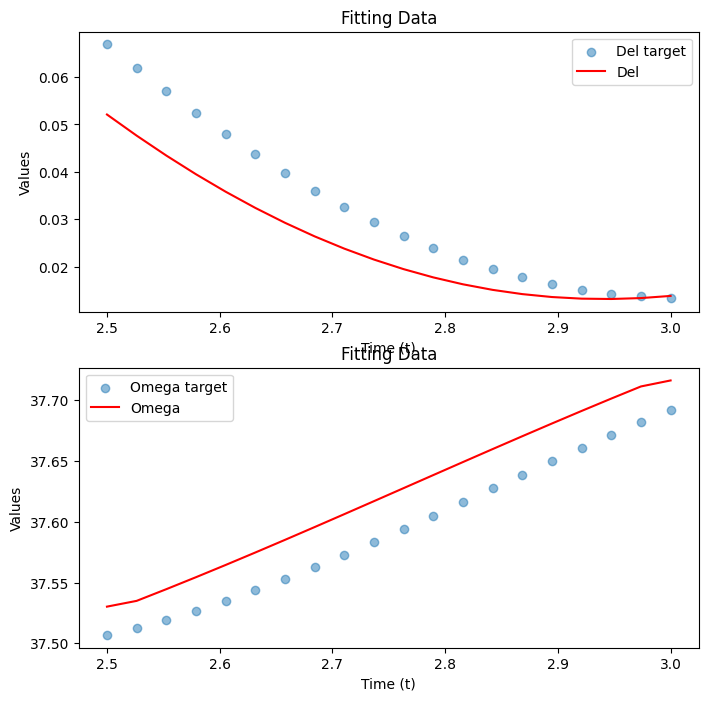

20
20
0.0138698833109667
37.71635213768094
[0.05208558 0.04763957 0.04344335 0.03950361 0.03582629 0.03241659
 0.02927896 0.0264171  0.02383391 0.02153153 0.01951132 0.01777387
 0.01631898 0.01514569 0.01425225 0.01363618 0.01329424 0.01322246
 0.01341614 0.01386988]
[37.53016176 37.53490779 37.54452677 37.55438571 37.56445658 37.57471088
 37.58511972 37.59565396 37.60628419 37.6169809  37.62771452 37.63845551
 37.64917443 37.65984206 37.67042943 37.68090792 37.69124935 37.70142607
 37.71141098 37.71635214]


In [20]:
import matplotlib.pyplot as plt

# Plot the target values and the fitted curve
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.scatter(t_data, del_target_values, label='Del target', alpha=0.5)
delta_pred = f(theta,w,t_data)
plt.plot(t_data, delta_pred, 'r', label='Del')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.legend()
plt.title('Fitting Data')


# Plot the target values and the fitted curve
# plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 2)
plt.scatter(t_data, omega_target_values, label='Omega target', alpha=0.5)

del_prime = np.gradient(delta_pred, t_data)
omega_pred = del_prime+ws

plt.plot(t_data, omega_pred, 'r', label='Omega')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.legend()
plt.title('Fitting Data')
plt.show()

# plt.show()
print(len(delta_pred))
print(len(omega_pred))
print(delta_pred[-1])
print(omega_pred[-1])

print(delta_pred)
print(omega_pred)